# Figure 4 - Background-averaged fitness effects (+ Supp. Figs.)

In [27]:
# load external dependencies
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
import matplotlib.transforms as transforms
%matplotlib inline

import math

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

from itertools import *

import random
import pandas as pd # (*) Pandas for data manipulation
import numpy as np
import scipy as sp
import os,glob

# load internal dependencies
import colors,plot,stats,utils

%load_ext autoreload
%autoreload 2

from config import *
# absolute file path for data directory
from paths import *

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this experiment, we cross individuals of the ancestral population with pre-existing variation and mutant individuals from the evolved population. All of these are diploid cells which undergo sporulation (labelled *spores*) and mating (creating *hybrids*). We evaluate phenotypes of the spore and hybrid genotypes. Phenotypic variation can then be attributed to allelic complementation (that is, dominance effects) or to non-allelic complementation (that is, epistasis).

## Spores

In [28]:
# load data
spores_abs_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_spores_abs.pickle')
spores_norm_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_spores_norm.pickle')

# filter out blank positions and constructs
spores_norm_df = spores_norm_df[~(spores_norm_df['strain'].isin(['control','']))&\
                                ~(spores_norm_df['genotype_long'].isin([u'fpr1Δ',u'tor1Δ']))]

# set contaminated samples as missing (NaN)
spores_norm_df.loc[(spores_norm_df['contamination']=='yes'),'growth_rate'] = np.nan

spores_norm_df['individual'] = zip(spores_norm_df['group'],
                                   spores_norm_df['background'],
                                   spores_norm_df['gene'],
                                   spores_norm_df['tetrad'],
                                   spores_norm_df['spore'])

# remove NaNs
# spores_norm_df = spores_norm_df[np.isfinite(spores_norm_df['growth_rate'])]

spores_norm_df.head()  # show dataframe header to stdout

,layout,plate,row,column,selection,environment,ID_YJH,strain,ID,group,...,spore,mating,auxotrophy,genotype_short,genotype_long,amino_acids,contamination,doubling_time,growth_rate,individual
0,0,0,0,0,HU,HU,1903,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,2,MATα,lys2-,+,RNR4,,no,0.197277,0.872196,"(evolved, WAxNA, RNR4, A, 2)"
1,0,0,0,1,HU,HU,1903,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,2,MATα,lys2-,+,RNR4,,no,0.482655,0.715659,"(evolved, WAxNA, RNR4, A, 2)"
2,0,0,0,2,HU,HU,1903,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,2,MATα,lys2-,+,RNR4,,no,0.517250,0.698703,"(evolved, WAxNA, RNR4, A, 2)"
3,0,0,0,3,HU,HU,1903,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,2,MATα,lys2-,+,RNR4,,no,0.554730,0.680785,"(evolved, WAxNA, RNR4, A, 2)"
4,0,0,0,4,HU,HU,1909*,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,4,MATα,lys2-,-,RNR4*,R34I,no,0.276690,0.825483,"(evolved, WAxNA, RNR4, B, 4)"


In [29]:
# load data
order=['selection','environment','layout','plate','row','column',
       'group','background','gene','genotype_short','genotype_long','amino_acids',
       'tetrad','spore','mating','auxotrophy','contamination','growth_rate']#,'lag','yield']

df = spores_norm_df

df = df.sort_values(['selection','environment','layout','plate','row','column'])
# df[order].to_csv(dir_data+'pheno/genetic-cross/pheno_spores_norm.csv', index=False, encoding='utf-8')

## Hybrids

In [30]:
# load data
hybrids_abs_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_hybrids_abs.pickle')
hybrids_norm_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_hybrids_norm.pickle')

# filter out blank positions, contamination and constructs
hybrids_norm_df = hybrids_norm_df[~(hybrids_norm_df['strain'].isin([('control','control'),('','')]))&\
                                  ~(hybrids_norm_df['genotype_long'].isin([u'fpr1Δ',u'tor1Δ']))]

# set contaminated samples as missing (NaN)
hybrids_norm_df.loc[hybrids_norm_df['contamination'].isin([('yes','yes'),('no','yes'),('yes','no')]),'growth_rate'] = np.nan

hybrids_norm_df['individual'] = zip(hybrids_norm_df['group'],
                                    hybrids_norm_df['background'],
                                    hybrids_norm_df['gene'],
                                    hybrids_norm_df['tetrad'],
                                    hybrids_norm_df['spore'])

# remove NaNs
# hybrids_norm_df = hybrids_norm_df[np.isfinite(hybrids_norm_df['growth_rate'])]

hybrids_norm_df.head()  # show dataframe header to stdout

,layout,plate,row,column,selection,environment,MATa,strain_MATa,ID_MATa,group_MATa,...,genotype_short,genotype_long,amino_acids,auxotrophy,mating,tetrad,spore,strain,contamination,individual
14976,11,0,14,32,RM,RM,2104,spore,WAxNA_F12_1_RM_2_T32_C3,evolved,...,"(+, +)","(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATa, MATα)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."
14977,11,0,14,33,RM,RM,2104,spore,WAxNA_F12_1_RM_2_T32_C3,evolved,...,"(+, +)","(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATa, MATα)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."
14978,11,0,15,32,RM,RM,2104,spore,WAxNA_F12_1_RM_2_T32_C3,evolved,...,"(+, +)","(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATa, MATα)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."
14979,11,1,14,32,RM,YNB,2104,spore,WAxNA_F12_1_RM_2_T32_C3,evolved,...,"(+, +)","(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATa, MATα)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."
14980,11,1,14,33,RM,YNB,2104,spore,WAxNA_F12_1_RM_2_T32_C3,evolved,...,"(+, +)","(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATa, MATα)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."


In [31]:
# load data
order=['selection','environment','layout','plate','row','column',
       u'strain_MATa',u'strain_MATα',
       u'group_MATa',u'group_MATα',u'background_MATa',u'background_MATα',u'gene_MATa',u'gene_MATα',
       u'genotype_short_MATa',u'genotype_short_MATα',u'genotype_long_MATa',u'genotype_long_MATα',
       u'amino_acids_MATa',u'amino_acids_MATα',u'contamination_MATa',u'contamination_MATα',
       u'tetrad_MATa',u'tetrad_MATα',u'spore_MATa',u'spore_MATα',u'mating_MATa',u'mating_MATα',
       u'auxotrophy_MATa',u'auxotrophy_MATα','growth_rate','lag','yield']

df = hybrids_abs_df

df = df.sort_values(['selection','environment','layout','plate','row','column'])
# df[order].to_csv(dir_data+'pheno/genetic-cross/pheno_hybrids_abs.csv', index=False, encoding='utf-8')

#hybrid_abs_df.to_csv(dir_data+'hybrids/20150402_hybrids_abs_pheno_filtered_with_labels.txt', index=False, sep='\t')
#hybrid_norm_df.to_csv(dir_data+'hybrids/20150402_hybrids_norm_pheno_filtered_with_labels.txt', index=False, sep='\t')

## Clones

In [33]:
# load data
clone_norm_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_norm.pickle')

# filter out strains used for spatial control
clone_norm_df = clone_norm_df[(clone_norm_df.group == 'ancestral')|\
                              (clone_norm_df.group == 'evolved')]

clone_norm_df['genotype_short'] = map(lambda x: tuple(x.strip("/").split("/")),clone_norm_df['genotype_short'])
clone_norm_df['genotype_long'] = map(lambda x: tuple(x.strip("/").split("/")),clone_norm_df['genotype_long'])

clone_norm_df['group'] = zip(clone_norm_df.group, clone_norm_df.group)
clone_norm_df['background'] = zip(clone_norm_df.background, clone_norm_df.background)
clone_norm_df['gene'] = zip(clone_norm_df.gene, clone_norm_df.gene)
# clone_norm_df['genotype'] = zip(clone_norm_df.genotype, clone_norm_df.genotype)

# remove NaNs
# clone_norm_df = clone_norm_df[np.isfinite(clone_norm_df['growth_rate'])]

clone_norm_df.head()

,selection,environment,run,index,plate,row,column,id,id_plate,group,...,assignment,isolate,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,doubling_time,growth_rate
0,RM,RM,1,0,0,0,0,P1_A1,1,"(ancestral, ancestral)",...,,1,"(, )","(+, +)","(,)",,MATa/α,,-0.037316,1.026203
1,RM,RM,1,1,0,0,1,P2_A1,2,"(ancestral, ancestral)",...,,1,"(, )","(+, +)","(,)",,MATa/α,,0.101343,0.932165
2,RM,RM,1,2,0,0,2,P6_A1,6,"(evolved, evolved)",...,,1,"(, )","(+, +)","(,)",,MATa/α,,0.039118,0.973249
3,RM,RM,1,3,0,0,3,P7_A1,7,"(evolved, evolved)",...,,1,"(, )","(+, +)","(,)",,MATa/α,,-0.802399,1.743999
4,RM,RM,1,4,0,0,4,P1_A2,1,"(ancestral, ancestral)",...,,2,"(, )","(+, +)","(,)",,MATa/α,,0.235418,0.849439


## Genetic cross - Spores and hybrids

### Ensemble by background and genotype

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


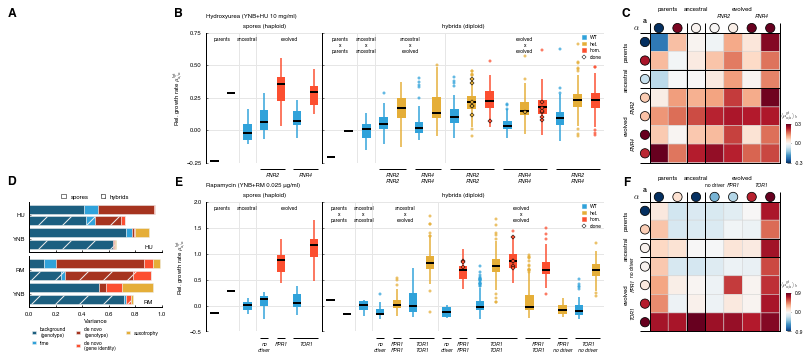

In [34]:
param='growth_rate'

fig = plt.figure(figsize=(12, 5), dpi=300)

grid = gridspec.GridSpec(2, 3, width_ratios=[1,3,1], hspace=0.3, wspace=0.2)

gs = {}
gs['schematic'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['variance'] = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios=[5,5,2], subplot_spec=grid[1,0], hspace=0.1)
gs[('HU','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,2])
gs[('HU','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[0,1], wspace=0)
gs[('RM','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,2])
gs[('RM','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[1,1], wspace=0)

### Schematic ###
ax = plt.subplot(gs['schematic'][:])
ax.text(-0.1, 1.15,  chr(ord('A')), transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='center', ha='right')
ax.axis('off')

### Box plots ###
groups_sp = spores_norm_df.groupby(['selection','environment'])
groups_hy = hybrids_norm_df.groupby(['selection','environment'])
groups_cl = clone_norm_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('RM','RM')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))
    
    # filter by dictionary
    S = S[(S['group'].isin(sp_bg_dict['position'][env_evo].keys())) &
          (S['genotype_short'].isin(sp_gt_short_dict['position'][env_evo].keys())) &
          (S['background'].isin(sp_cl_dict['position'][env_evo].keys()))]
    H = H[(H['group'].isin(hy_bg_dict['position'][env_evo].keys())) &
          (H['genotype_short'].isin(hy_gt_short_dict['position'][env_evo].keys())) &
          (H['background'].isin(hy_cl_dict['position'][env_evo].keys()))]
    
    # apply sorting ranks to reorder rows
    S.loc[:,'rank_group'] = S['group'].map(sp_bg_dict['position'][env_evo])
    S.loc[:,'rank_background'] = S['background'].map(sp_cl_dict['position'][env_evo])
    S.loc[:,'rank_gene'] = S['gene'].map(sp_gn_dict['position'][env_evo])
    S.loc[:,'rank_genotype'] = S['genotype_short'].map(sp_gt_short_dict['position'][env_evo])
    S.sort_values(['rank_group','rank_background','rank_gene','rank_genotype'],
                  ascending=True,inplace=True)

    H.loc[:,'rank_group'] = H['group'].map(hy_bg_dict['position'][env_evo])
    H.loc[:,'rank_background'] = H['background'].map(hy_cl_dict['position'][env_evo])
    H.loc[:,'rank_gene'] = H['gene'].map(hy_gn_dict['position'][env_evo])
    H.loc[:,'rank_genotype'] = H['genotype_short'].map(hy_gt_short_dict['position'][env_evo])
    H.sort_values(['rank_group','rank_background','rank_gene','rank_genotype'],
                  ascending=True,inplace=True)
    
    S_ref = S[S.group=='ancestral'].growth_rate.mean()
    H_ref = H[H.group==('ancestral','ancestral')].growth_rate.mean()
    
    ### spores barplot ###
    ax1 = plt.subplot(gs[(env_evo,'barplot')][:7])

    ax1.text(-0.2, 1.15,  chr(3*ii + ord('B')), transform=ax1.transAxes,
             fontsize=12, fontweight='bold', va='center', ha='right')
    
    ax1.text(0, 1.125,  dict_environment['long_label'][env_test], transform=ax1.transAxes,
             fontsize=6, va='center', ha='left')
    
    S = S.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    S = S-S_ref
    
    bp = S.plot(ax=ax1, kind='box', by='group', return_type='dict',
                labels=S.columns.get_level_values('group'))

    colors = [sp_gt_short_dict['color'][env_evo][x] for x in S.columns.get_level_values('genotype_short')]
    plot.boxplot_custom(bp, ax1, colors=colors, hatches=[' ']*10)
        
    ax1.set_title('spores (haploid)', fontsize=6, y=1)
    ax1.set_xlabel('')
    ax1.set_ylabel(r'Rel. growth rate $\mu^{bgt}_{a/\alpha}$', fontsize=6, labelpad=2)

    ### hybrids barplot ###
    ax2 = plt.subplot(gs[(env_evo,'barplot')][7:], sharey=ax1)
    
    H = H.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    H = H-H_ref
    
    C = C.groupby(['group','background','gene','genotype_short','isolate'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']
    C_ref = C[('ancestral', 'ancestral')].mean()

    C = C-C_ref
    C = C.unstack(level=['group','background','gene','genotype_short'])
    C = C.loc[:,(C.columns.get_level_values('group').isin([('evolved','evolved')])\
                 &~(C.columns.get_level_values('gene').isin([('','')])))]
    C = C.reindex(columns=H.columns)
    C = C.dropna(how='all')

    bp = H.plot(ax=ax2, kind='box', by='group', return_type='dict', 
                labels=H.columns.get_level_values('group'))

    colors = [hy_gt_short_dict['color'][env_evo][x] for x in H.columns.get_level_values('genotype_short')]
    plot.boxplot_custom(bp, ax2, colors=colors, hatches=[' ']*30)

    for i,d in enumerate(C):
        y = C[d]
        x = [i+1]*len(y)
        ax2.plot(x, y, 
                 mfc=hy_gt_short_dict['color'][env_evo][d[-1]], mec='k', 
                 ms=3, marker="D", linestyle="None")
    
    ax2.set_title('hybrids (diploid)', fontsize=6)
    ax2.set_xlabel('')
    ax2.set_ylabel('', fontsize=6)
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=hy_gt_short_dict['color'][env_evo][('+','+')])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=hy_gt_short_dict['color'][env_evo][('+','-')])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=hy_gt_short_dict['color'][env_evo][('-','-')])
    clone_artist = lines.Line2D((0,1),(0,0), mec='k', mfc='w', marker='D', markersize=3, linestyle='')

    leg = ax2.legend([wt_artist,het_artist,hom_artist,clone_artist], 
                     ['WT','het.','hom.','clone'], ncol=1, 
                     frameon=False, loc='upper right',
                     borderaxespad=0, handlelength=0.75, 
                     prop={'size':5}, labelspacing=.32)
        
    # Grid
    for ax, g in zip([ax1,ax2],[S,H]):
        
        ## background
        xstart, xend, xlabels = plot.set_custom_labels(g.columns, 0)
        # labels
        for k, v in xlabels.iteritems():
            ax.annotate('\nx\n'.join(k) if isinstance(k, tuple) else k, 
                        xy=(v+1, 0.97), xycoords=("data", "axes fraction"),
                        ha='center', va='top', annotation_clip=False, fontsize=5)
        # grid
        xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
        [ax.axvline(x, lw=1.0, ls='-', color='0.9', zorder=0) for x in xgrid]

        ## gene
        xend, xstart, xlabels = plot.set_custom_labels(g.columns, 2)
        
        transform = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        for k in xlabels:
            if (k!='') & (k!=('','')):
                if abs(xstart[k]-xend[k])>0:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                else:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                ax.add_line(line)
                line.set_clip_on(False)
        
        ax.set_xticks([x+1 for x in xlabels.values()], minor=False)
        di = {u'no driver': u'no\ndriver', u'/': u'',
              u'\nRNR2': u'RNR2\nRNR2', u'\nRNR4': u'RNR4\nRNR4',
              u'\nno driver': u'no\ndriver', u'no driver\nno driver': u'no\ndriver',
              u'\nFPR1': u'FPR1\nFPR1', u'\nTOR1': u'TOR1\nTOR1'}
        xlabels = ['\n'.join(k) if isinstance(k, tuple) else k for k in xlabels.keys()]
        xlabels = [di[x] if x in di else x for x in xlabels]
        ax.set_xticklabels(xlabels, minor=False, fontsize=5, style='italic', va='top')
        
        ax.axhline(y=0., c='k', lw=0.5, zorder=0)
                
        ax.tick_params(axis='x', which='minor', size=0, pad=-30)
        ax.tick_params(axis='x', which='major', size=0, pad=10)
        ax.tick_params(axis='y', which='major', labelsize=6)
        
        if env_evo=='HU':
            ax.set_ylim(-0.25,0.75)
            ax.yaxis.set_major_locator( MaxNLocator(nbins = 5) )
            ax.yaxis.set_minor_locator( MaxNLocator(nbins = 5) )
        elif env_evo=='RM':
            ax.set_ylim(-0.5,2.0)
            ax.yaxis.set_major_locator( MaxNLocator(nbins = 5) )
            ax.yaxis.set_minor_locator( MaxNLocator(nbins = 5) )

### Heatmaps ###
for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('RM','RM')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))

    # apply sorting ranks to reorder rows
    S.loc[:,u'rank_group'] = S[u'group'].map(dict_population['position'])
    S.loc[:,u'rank_background'] = S[u'background'].map(dict_background['position'])
    S.loc[:,u'rank_genotype'] = S[u'genotype_short'].map(dict_genotype['position'])
    S.loc[:,u'rank_gene'] = S[u'gene'].map(dict_gene['position'])
    S.sort_values(by=[u'rank_group',u'rank_background',u'rank_genotype',u'rank_gene'],
                  ascending=True,inplace=True)
    
    H.loc[:,u'rank_group_MATa'] = H[u'group_MATa'].map(dict_population['position'])
    H.loc[:,u'rank_group_MATα'] = H[u'group_MATα'].map(dict_population['position'])
    H.loc[:,u'rank_background_MATa'] = H[u'background_MATa'].map(dict_background['position'])
    H.loc[:,u'rank_background_MATα'] = H[u'background_MATα'].map(dict_background['position'])
    H.loc[:,u'rank_genotype_MATa'] = H[u'genotype_short_MATa'].map(dict_genotype['position'])
    H.loc[:,u'rank_genotype_MATα'] = H[u'genotype_short_MATα'].map(dict_genotype['position'])
    H.loc[:,u'rank_gene_MATa'] = H[u'gene_MATa'].map(dict_gene['position'])
    H.loc[:,u'rank_gene_MATα'] = H[u'gene_MATα'].map(dict_gene['position'])
    H.sort_values(by=[u'rank_group_MATa',u'rank_group_MATα',
                      u'rank_background_MATa',u'rank_background_MATα',
                      u'rank_gene_MATa',u'rank_gene_MATα',
                      u'rank_genotype_MATa',u'rank_genotype_MATα'],
                  ascending=True, inplace=True)

    ax = plt.subplot(gs[(env_evo,'heatmap')][:])
        
    ax.text(-0.15, 1.15,  chr(3*ii + ord('C')), transform=ax.transAxes,
             fontsize=12, fontweight='bold', va='center', ha='right')
    
    # spores
    S = S.groupby([u'mating',u'group',u'background',u'genotype_short',u'gene'],
                    sort=False).agg(np.mean)[param]
    S_ref = S.ix[:,'ancestral'].mean()
    S = S-S_ref
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    
    plot.heatmap_spores(S, ax, title, 
                        xlabel, ylabel, xticklabels, yticklabels, 
                        cmap=plt.cm.RdBu_r, radius=0.25)
    
    # hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'],
                    sort=False).agg(np.mean)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'])
    H_ref = H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'].values.squeeze()
    H = H-H_ref

    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = H.values.max()
    vmin = -vmax
    legend_title = r'$\langle \mu^{gt}_{a/\alpha}\rangle_b$'
    
    plot.heatmap_hybrids(H, ax, title,
                         xlabel, ylabel, xticklabels, yticklabels, 
                         fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
                         vmin=vmin, vmax=vmax, pad=30)
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.01, 1.1), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.1, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    
    ## gene
    # labels
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(v+0.5, 1.15), xycoords=("data", "axes fraction"),
                    ha='center', va='top', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5)
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(-0.15, v+0.5), xycoords=("axes fraction", "data"),
                    ha='left', va='center', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5, rotation=90)
    
    ## background
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    ax.set_xticks([x+0.5 for x in xlabels.values()], minor=False)
    ax.set_xticklabels(xlabels.keys(), minor=False, fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=1, ls="-", color="black") for g in xgrid]
    
    ystart, yend, ylabels= plot.set_custom_labels(H.columns, 0)
    ax.set_yticks([y+0.5 for y in ylabels.values()], minor=False)
    ax.set_yticklabels(ylabels.keys(), minor=False, fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=1, ls="-", color="black") for g in ygrid]

    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-.5], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-.5], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=10)
    ax.tick_params(axis='both', which='major', size=0, pad=21)

### Variance components ###
sdf = spores_norm_df
sdf = sdf[sdf.group.isin(['ancestral','evolved'])]
sdf = sdf[np.isfinite(sdf['growth_rate'])]

hdf = hybrids_norm_df
hdf = hdf[hdf.group.isin([('ancestral','ancestral'),('ancestral','evolved'),('evolved','evolved')])]
hdf = hdf[np.isfinite(hdf['growth_rate'])]

formula = 'growth_rate ~ C(group) + C(gene) + C(genotype_short) + C(auxotrophy) + C(individual)'
tsdf = sdf.groupby(['selection','environment']).apply(stats.variance_vectors, formula) 
thdf = hdf.groupby(['selection','environment']).apply(stats.variance_vectors, formula)
df = pd.concat([tsdf, thdf], keys=['spores','hybrids'], names=['type'])
      
# fix columns
df = df.rename(
    columns={
        'C(group)':'time',
        'C(gene)':'de novo\n(gene identity)',
        'C(genotype_short)':'de novo\n(genotype)',
        'C(auxotrophy)':'auxotrophy',
        'C(individual)':'background\n(genotype)',
    }
)

# fix columns
order = ['background\n(genotype)','time','de novo\n(genotype)','de novo\n(gene identity)','auxotrophy']
order = [val for val in order if val in df.columns]
df = df[order]

# fix index
df = df.swaplevel('type', 'selection')
df = df.swaplevel('type', 'environment')
df = df.sort_index(level=['selection','environment','type'])
df = df.sort_index(ascending=False)

axes = {}

for ii, (env_evo, ge) in enumerate(df.groupby(level='selection')):
        
    if env_evo=='HU':
        axes[env_evo] = plt.subplot(gs['variance'][ii])
        axes[env_evo].text(-0.1, 1.4,  chr(ord('D')), transform=axes[env_evo].transAxes,
                           fontsize=12, fontweight='bold', va='center', ha='right')
    else:
        axes[env_evo] = plt.subplot(gs['variance'][ii], sharex=axes['HU'])
        
    ax = axes[env_evo]
    utils.simple_axes(ax)
    
    ge.plot(ax=ax, kind='barh', stacked=True, 
            color=[factor_dict['color'][x] for x in ge.columns],
            align='center', legend=False, width=0.75)
    
    if env_evo=='RM':
        leg2 = ax.legend(bbox_to_anchor=(0.5, -0.9), ncol=3, 
                         frameon=False, loc='lower center',
                         borderaxespad=0, handlelength=0.75, prop={'size':5})
    
    bars = ax.patches
    hatches = ''.join([factor_dict['hatch'][x] for x in ge.index.get_level_values('type')]*len(ge))

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    # x-axis
    ax.set_xlabel('Variance', fontsize=6, labelpad=2, visible=True)
    # y-axis
    ax.set_ylabel('')
    ystart, yend, ylabels = plot.set_custom_labels(ge.index, 1)
    ax.set_yticks(ylabels.values())
    ax.set_yticklabels(ylabels.keys(), fontsize=6)
    
    # annotate panels and axis
    ax.annotate(env_evo, xy=(0.9, 0.05), 
                xycoords=('axes fraction', 'axes fraction'),
                ha='center', va='bottom', fontsize=6)
    
    ax.tick_params(axis='both', which='major', labelsize=6, size=2)
    
# Fix x-axis labels (missing due to boxplot styling)
axes['RM'].xaxis.set_visible(True)
plt.setp(axes['RM'].get_xticklabels(), visible=True)
    
s_artist = patches.Rectangle((0,0), width=1, height=1, 
                             facecolor='w', edgecolor='k')
h_artist = patches.Rectangle((0,0), width=1, height=1, hatch='///', 
                             facecolor='w', edgecolor='k')

leg2 = axes['HU'].legend([s_artist,h_artist], ['spores','hybrids'],
                         bbox_to_anchor=(0.5, 1.2), ncol=2, 
                         frameon=False, loc='upper center',
                         borderaxespad=0, handlelength=0.75, prop={'size':6})

fig.savefig(dir_paper+'figures/figure4/figure4.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure4/figure4.svg', dpi=300, bbox_inches='tight')
plt.show()

Fig. 4: Fitness contribution of genetic background and *de novo* mutations. (A) To determine fitness effects of background variation and de novo mutations in HU (*RNR2*, *RNR4*) and RM (*FPR1*, *TOR1*), we isolated individuals from ancestral and evolved populations. From these diploid cells, we sporulated and selected haploid segregants of each mating type. Spores with heterozygous mutations in *RNR2*, *RNR4* and *TOR1* were genotyped to test if they carry the wild type or mutated allele. We crossed the MATa and MATα versions to create hybrids (48x48 in HU and 56x56 in RM). Independent segregants were used to measure biological variability of ancestral and evolved backgrounds. All other panels follow this legend. (B and E) Relative growth rate, , measured with respect to the ancestral population for multiple combinations (background, ; genotype, ; individual, ) and averaged over  measurement replicates. Medians and the 25% / 75% percentiles across groups are shown, with medians as horizontal lines and colored by de novo genotype [wildtype +/+ (blue); heterozygote +/- (yellow); homozygote -/- (red)]. Outliers (circles) and isolated, selected clones with matching genotypes (diamonds) are highlighted. (D) Variance decomposition of the group means for spores (solid) and hybrids (hatched) that can be attributed to different components, excluding the parents. The sum of squares is used to compare deviations in the ratio of between- and within-group variance. Corrected for multiple testing. (C and F) Mean growth rate of the spores and the hybrids. An extended version of the figure with all combinations and controls can be found in Figs. SX and SX.

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


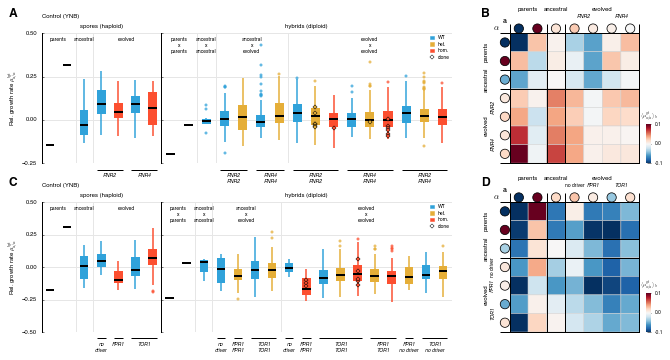

In [9]:
param='growth_rate'

fig = plt.figure(figsize=(9.6, 5), dpi=300)

grid = gridspec.GridSpec(2, 2, width_ratios=[3,1], hspace=0.3, wspace=0.2)

gs = {}
gs[('HU','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[0,0], wspace=0)
gs[('HU','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1,subplot_spec=grid[0,1])
gs[('RM','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[1,0], wspace=0)
gs[('RM','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,1])

### Box plots ###
groups_sp = spores_norm_df.groupby(['selection','environment'])
groups_hy = hybrids_norm_df.groupby(['selection','environment'])
groups_cl = clone_norm_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','YNB'),('RM','YNB')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))
    
    # filter by dictionary
    S = S[(S['group'].isin(sp_bg_dict['position'][env_evo].keys())) &
          (S['genotype_short'].isin(sp_gt_short_dict['position'][env_evo].keys())) &
          (S['background'].isin(sp_cl_dict['position'][env_evo].keys()))]
    H = H[(H['group'].isin(hy_bg_dict['position'][env_evo].keys())) &
          (H['genotype_short'].isin(hy_gt_short_dict['position'][env_evo].keys())) &
          (H['background'].isin(hy_cl_dict['position'][env_evo].keys()))]
    
    # apply sorting ranks to reorder rows
    S.loc[:,'rank_group'] = S['group'].map(sp_bg_dict['position'][env_evo])
    S.loc[:,'rank_background'] = S['background'].map(sp_cl_dict['position'][env_evo])
    S.loc[:,'rank_gene'] = S['gene'].map(sp_gn_dict['position'][env_evo])
    S.loc[:,'rank_genotype'] = S['genotype_short'].map(sp_gt_short_dict['position'][env_evo])
    S.sort_values(['rank_group','rank_background','rank_gene','rank_genotype'],
                  ascending=True,inplace=True)

    H.loc[:,'rank_group'] = H['group'].map(hy_bg_dict['position'][env_evo])
    H.loc[:,'rank_background'] = H['background'].map(hy_cl_dict['position'][env_evo])
    H.loc[:,'rank_gene'] = H['gene'].map(hy_gn_dict['position'][env_evo])
    H.loc[:,'rank_genotype'] = H['genotype_short'].map(hy_gt_short_dict['position'][env_evo])
    H.sort_values(['rank_group','rank_background','rank_gene','rank_genotype'],
                  ascending=True,inplace=True)
    
    S_ref = S[S.group=='ancestral'].growth_rate.mean()
    H_ref = H[H.group==('ancestral','ancestral')].growth_rate.mean()
    
    ### spores barplot ###
    ax1 = plt.subplot(gs[(env_evo,'barplot')][:7])

    ax1.text(-0.2, 1.15,  chr(2*ii + ord('A')), transform=ax1.transAxes,
             fontsize=12, fontweight='bold', va='center', ha='right')
    
    ax1.text(0, 1.125,  dict_environment['long_label'][env_test], transform=ax1.transAxes,
             fontsize=6, va='center', ha='left')
    
    S = S.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    S = S-S_ref
    
    bp = S.plot(ax=ax1, kind='box', by='group', return_type='dict',
                labels=S.columns.get_level_values('group'))

    plot.boxplot_custom(bp, ax1,
                        colors=[sp_gt_short_dict['color'][env_evo][x] for x in S.columns.get_level_values('genotype_short')],
                        hatches=[' ']*10)
    
    ax1.set_title('spores (haploid)', fontsize=6)
    ax1.set_xlabel('')
    ax1.set_ylabel(r'Rel. growth rate $\mu^{bgt}_{a/\alpha}$', fontsize=6, labelpad=2)

    ### hybrids barplot ###
    ax2 = plt.subplot(gs[(env_evo,'barplot')][7:], sharey=ax1)
    
    H = H.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    H = H-H_ref
    
    C = C.groupby(['group','background','gene','genotype_short','isolate'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']
    C_ref = C[('ancestral', 'ancestral')].mean()

    C = C-C_ref
    C = C.unstack(level=['group','background','gene','genotype_short'])
    C = C.loc[:,(C.columns.get_level_values('group').isin([('evolved','evolved')])\
                 &~(C.columns.get_level_values('gene').isin([('','')])))]
    C = C.reindex(columns=H.columns)
    C = C.dropna(how='all')

    bp = H.plot(ax=ax2, kind='box', by='group', return_type='dict', 
                labels=H.columns.get_level_values('group'))

    plot.boxplot_custom(bp, ax2, 
                        colors=[hy_gt_short_dict['color'][env_evo][x] for x in H.columns.get_level_values('genotype_short')],
                        hatches=[' ']*30)

    for i,d in enumerate(C):
        y = C[d]
        x = [i+1]*len(y)
        ax2.plot(x, y, 
                 mfc=hy_gt_short_dict['color'][env_evo][d[-1]], mec='k', 
                 ms=3, marker="D", linestyle="None")
    
    ax2.set_title('hybrids (diploid)', fontsize=6)
    ax2.set_xlabel('')
    ax2.set_ylabel('', fontsize=6)
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=hy_gt_short_dict['color'][env_evo][('+','+')])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=hy_gt_short_dict['color'][env_evo][('+','-')])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=hy_gt_short_dict['color'][env_evo][('-','-')])
    clone_artist = lines.Line2D((0,1),(0,0), mec='k', mfc='w', marker='D', markersize=3, linestyle='')

    leg = ax2.legend([wt_artist,het_artist,hom_artist,clone_artist], 
                     ['WT','het.','hom.','clone'], ncol=1, 
                     frameon=False, loc='upper right',
                     borderaxespad=0, handlelength=0.75, 
                     prop={'size':5}, labelspacing=.32)
        
    # Grid
    for ax, g in zip([ax1,ax2],[S,H]):
        
        ## background
        xstart, xend, xlabels = plot.set_custom_labels(g.columns, 0)
        # labels
        for k, v in xlabels.iteritems():
            ax.annotate('\nx\n'.join(k) if isinstance(k, tuple) else k, 
                        xy=(v+1, 0.97), xycoords=("data", "axes fraction"),
                        ha='center', va='top', annotation_clip=False, fontsize=5)
        # grid
        xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
        [ax.axvline(x, lw=1.0, ls="-", color="0.9") for x in xgrid]

        ## gene
        xend, xstart, xlabels = plot.set_custom_labels(g.columns, 2)
        
        transform = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        for k in xlabels:
            if (k!='') & (k!=('','')):
                if abs(xstart[k]-xend[k])>0:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                else:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                ax.add_line(line)
                line.set_clip_on(False)
        
        ax.set_xticks([x+1 for x in xlabels.values()], minor=False)
        di = {u'no driver': u'no\ndriver', u'/': u'',
              u'\nRNR2': u'RNR2\nRNR2', u'\nRNR4': u'RNR4\nRNR4',
              u'\nno driver': u'no\ndriver', u'no driver\nno driver': u'no\ndriver',
              u'\nFPR1': u'FPR1\nFPR1', u'\nTOR1': u'TOR1\nTOR1'}
        xlabels = ['\n'.join(k) if isinstance(k, tuple) else k for k in xlabels.keys()]
        xlabels = [di[x] if x in di else x for x in xlabels]
        ax.set_xticklabels(xlabels, minor=False, fontsize=5, style='italic', va='top')
                
        ax.tick_params(axis='x', which='minor', size=0, pad=-30)
        ax.tick_params(axis='x', which='major', size=0, pad=10)
        ax.tick_params(axis='y', which='major', labelsize=6)
        
        if env_evo=='HU':
            ax.set_ylim(-0.25,0.5)
            ax.yaxis.set_major_locator( MaxNLocator(nbins = 4) )
            ax.yaxis.set_minor_locator( MaxNLocator(nbins = 4) )
        elif env_evo=='RM':
            ax.set_ylim(-0.5,0.5)
            ax.yaxis.set_major_locator( MaxNLocator(nbins = 4) )
            ax.yaxis.set_minor_locator( MaxNLocator(nbins = 4) )

### Heatmaps ###
for (ii, (env_evo, env_test)) in enumerate([('HU','YNB'),('RM','YNB')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))

    # apply sorting ranks to reorder rows
    S.loc[:,u'rank_group'] = S[u'group'].map(dict_population['position'])
    S.loc[:,u'rank_background'] = S[u'background'].map(dict_background['position'])
    S.loc[:,u'rank_genotype'] = S[u'genotype_short'].map(dict_genotype['position'])
    S.loc[:,u'rank_gene'] = S[u'gene'].map(dict_gene['position'])
    S.sort_values(by=[u'rank_group',u'rank_background',u'rank_genotype',u'rank_gene'],
                  ascending=True,inplace=True)
    
    H.loc[:,u'rank_group_MATa'] = H[u'group_MATa'].map(dict_population['position'])
    H.loc[:,u'rank_group_MATα'] = H[u'group_MATα'].map(dict_population['position'])
    H.loc[:,u'rank_background_MATa'] = H[u'background_MATa'].map(dict_background['position'])
    H.loc[:,u'rank_background_MATα'] = H[u'background_MATα'].map(dict_background['position'])
    H.loc[:,u'rank_genotype_MATa'] = H[u'genotype_short_MATa'].map(dict_genotype['position'])
    H.loc[:,u'rank_genotype_MATα'] = H[u'genotype_short_MATα'].map(dict_genotype['position'])
    H.loc[:,u'rank_gene_MATa'] = H[u'gene_MATa'].map(dict_gene['position'])
    H.loc[:,u'rank_gene_MATα'] = H[u'gene_MATα'].map(dict_gene['position'])
    H.sort_values(by=[u'rank_group_MATa',u'rank_group_MATα',
                      u'rank_background_MATa',u'rank_background_MATα',
                      u'rank_gene_MATa',u'rank_gene_MATα',
                      u'rank_genotype_MATa',u'rank_genotype_MATα'],
                  ascending=True, inplace=True)

    ax = plt.subplot(gs[(env_evo,'heatmap')][:])
        
    ax.text(-0.15, 1.15,  chr(2*ii + ord('B')), transform=ax.transAxes,
             fontsize=12, fontweight='bold', va='center', ha='right')
    
    # spores
    S = S.groupby([u'mating',u'group',u'background',u'genotype_short',u'gene'],
                    sort=False).agg(np.mean)[param]
    S_ref = S.ix[:,'ancestral'].mean()
    S = S-S_ref
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    
    plot.heatmap_spores(S, ax, title, 
                        xlabel, ylabel, xticklabels, yticklabels, 
                        cmap=plt.cm.RdBu_r, radius=0.25)
    
    # hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'],
                    sort=False).agg(np.mean)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'])
    H_ref = H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'].values.squeeze()
    H = H-H_ref

    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = H.values.max()
    vmin = -vmax
    legend_title = r'$\langle \mu^{gt}_{a/\alpha}\rangle_b$'
    
    plot.heatmap_hybrids(H, ax, title,
                         xlabel, ylabel, xticklabels, yticklabels, 
                         fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
                         vmin=vmin, vmax=vmax, pad=30)
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.01, 1.1), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.1, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    
    ## gene
    # labels
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(v+0.5, 1.15), xycoords=("data", "axes fraction"),
                    ha='center', va='top', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5)
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(-0.15, v+0.5), xycoords=("axes fraction", "data"),
                    ha='left', va='center', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5, rotation=90)
    
    ## background
    # labels and grid
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    ax.set_xticks([x+0.5 for x in xlabels.values()], minor=False)
    ax.set_xticklabels(xlabels.keys(), minor=False, fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=1, ls="-", color="black") for g in xgrid]
    
    ystart, yend, ylabels= plot.set_custom_labels(H.columns, 0)
    ax.set_yticks([y+0.5 for y in ylabels.values()], minor=False)
    ax.set_yticklabels(ylabels.keys(), minor=False, fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=1, ls="-", color="black") for g in ygrid]

    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-.5], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-.5], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=10)
    ax.tick_params(axis='both', which='major', size=0, pad=21)

fig.savefig(dir_supp+'figures/figureSX_pheno_cross/figureSX_pheno_cross_reduced.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_pheno_cross/figureSX_pheno_cross_reduced.svg', dpi=300, bbox_inches='tight')
plt.show()

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


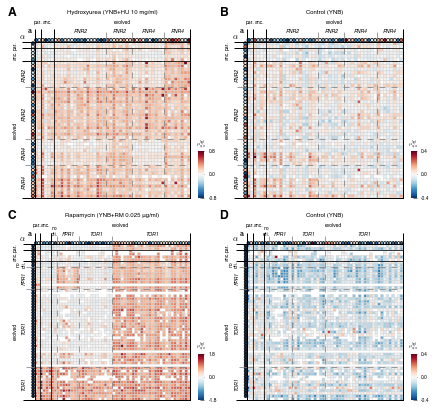

In [11]:
param='growth_rate'

fig = plt.figure(figsize=(6, 6), dpi=300)

grid = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.3)

gs = {}
gs[('HU','HU')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs[('HU','YNB')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,1])
gs[('RM','RM')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,0])
gs[('RM','YNB')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,1])

groups_sp = spores_norm_df.groupby(['selection','environment'])
groups_hy = hybrids_norm_df.groupby(['selection','environment'])
groups_cl = clone_norm_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('HU','YNB'),('RM','RM'),('RM','YNB')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))

    # apply sorting ranks to reorder rows
    S.loc[:,u'rank_group'] = S[u'group'].map(dict_population['position'])
    S.loc[:,u'rank_background'] = S[u'background'].map(dict_background['position'])
    S.loc[:,u'rank_gene'] = S[u'gene'].map(dict_gene['position'])
    S.loc[:,u'rank_genotype'] = S[u'genotype_short'].map(dict_genotype['position'])
    S.sort_values(by=[u'rank_group',u'rank_background',u'rank_gene',u'rank_genotype'],
                    ascending=True,inplace=True)
    
    H.loc[:,u'rank_group_MATa'] = H[u'group_MATa'].map(dict_population['position'])
    H.loc[:,u'rank_group_MATα'] = H[u'group_MATα'].map(dict_population['position'])
    H.loc[:,u'rank_background_MATa'] = H[u'background_MATa'].map(dict_background['position'])
    H.loc[:,u'rank_background_MATα'] = H[u'background_MATα'].map(dict_background['position'])
    H.loc[:,u'rank_gene_MATa'] = H[u'gene_MATa'].map(dict_gene['position'])
    H.loc[:,u'rank_gene_MATα'] = H[u'gene_MATα'].map(dict_gene['position'])
    H.loc[:,u'rank_genotype_MATa'] = H[u'genotype_short_MATa'].map(dict_genotype['position'])
    H.loc[:,u'rank_genotype_MATα'] = H[u'genotype_short_MATα'].map(dict_genotype['position'])
    H.sort_values(by=[u'rank_group_MATa',u'rank_group_MATα',
                      u'rank_background_MATa',u'rank_background_MATα',
                      u'rank_gene_MATa',u'rank_gene_MATα',
                      u'rank_genotype_MATa',u'rank_genotype_MATα'],
                    ascending=True, inplace=True)

    ### heatmap ###
    ax = plt.subplot(gs[(env_evo, env_test)][0])
    
    ax.text(-0.12, 1.225,  chr(ii + ord('A')), transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='right')
    
    # spores
    S = S.groupby([u'mating',u'group',u'background',u'gene',u'genotype_short',u'tetrad',u'spore'],
                    sort=False)[param].agg(np.std).reset_index()
    S = S.set_index('mating')[param]
    S_ref = np.nanmean(S.values)
    S = S-S_ref
        
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    
    plot.heatmap_spores(S, ax, title, 
                        xlabel, ylabel, xticklabels, yticklabels, 
                        cmap=plt.cm.RdBu_r, radius=0.5)
    
    # hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',u'tetrad_MATa',u'spore_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα',u'tetrad_MATα',u'spore_MATα'],
                    sort=False).agg(np.median)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα',u'tetrad_MATα',u'spore_MATα'])
    H_ref = np.nanmean(H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'])
    H = H-H_ref

    title = dict_environment['long_label'][env_test]
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(np.nanmin(H), np.nanmax(H), key=abs)
    vmin = -vmax
    legend_title = r'$\mu^{bgt}_{a/\alpha}$'
    
    plot.heatmap_hybrids(H, ax, title,
                         xlabel, ylabel, xticklabels, yticklabels, 
                         fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
                         vmin=vmin, vmax=vmax, pad=30)
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.01, 1.075), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.075, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    
    ## gene + genotype
    # labels and grid
    
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, slice(2, 4))
    for k, v in xlabels.iteritems():
        ax.annotate(k[0].replace('no driver','no\ndri.'), xy=(v+0.5, 1.05), xycoords=("data", "axes fraction"),
                    ha='center', va='bottom', annotation_clip=False, 
                    style=('italic' if k[0]!='no driver' else 'normal'), fontsize=5)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=.75, ls="--", color="gray") for g in xgrid]
    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-3], color='gray', ls='-', lw=.75)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ystart, yend, ylabels = plot.set_custom_labels(H.index, slice(2, 4))
    for k, v in ylabels.iteritems():
        ax.annotate(k[0].replace('no driver','no\ndri.'), xy=(-0.05, v+0.5), xycoords=("axes fraction", "data"),
                    ha='right', va='center', annotation_clip=False,  
                    style=('italic' if k[0]!='no driver' else 'normal'), fontsize=5, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=.75, ls="--", color="gray") for g in ygrid]
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-3], [y+1,y+1], color='gray', ls='-', lw=.75)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ## background
    # labels and grid
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    for k, v in xlabels.iteritems():
        ax.annotate(dict_population['short_label'][k], xy=(v+0.5, dict_population['pad'][k]+1), xycoords=("data", "axes fraction"),
                    ha='center', va='bottom', annotation_clip=False, fontsize=5)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=.75, ls="-", color="k") for g in xgrid]
    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-4], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 0)
    for k, v in ylabels.iteritems():
        ax.annotate(dict_population['short_label'][k], xy=(-dict_population['pad'][k], v+0.5), xycoords=("axes fraction", "data"),
                    ha='right', va='center', annotation_clip=False, fontsize=5, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=.75, ls="-", color="k") for g in ygrid]
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-4], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=2)
    ax.tick_params(axis='both', which='major', size=0, pad=15)

fig.savefig(dir_supp+'figures/figureSX_pheno_cross/figureSX_pheno_cross_extended.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_pheno_cross/figureSX_pheno_cross_extended.svg', dpi=300, bbox_inches='tight')
plt.show()

## Analysis of variance

### ANOVA (frequentist)

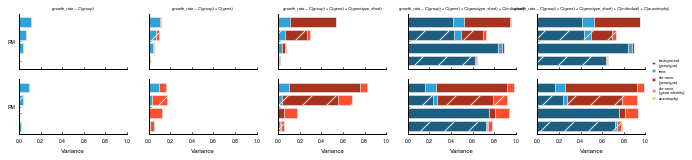

In [13]:
sdf = spores_norm_df
sdf = sdf[sdf.group.isin(['ancestral','evolved'])]
sdf = sdf[np.isfinite(sdf['growth_rate'])]

hdf = hybrids_norm_df
hdf = hdf[hdf.group.isin([('ancestral','ancestral'),('ancestral','evolved'),('evolved','evolved')])]
hdf = hdf[np.isfinite(hdf['growth_rate'])]
    
formulas = ['growth_rate ~ C(group)',
            'growth_rate ~ C(group) + C(gene)',
            'growth_rate ~ C(group) + C(gene) + C(genotype_short)',
            'growth_rate ~ C(group) + C(gene) + C(genotype_short) + C(individual)',
            'growth_rate ~ C(group) + C(gene) + C(genotype_short) + C(individual) + C(auxotrophy)']

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 2), sharex=True, sharey=True)

for ii, formula in enumerate(formulas):
    
    msdf = sdf.groupby(['selection','environment']).apply(stats.mean_vectors, formula) 
    mhdf = hdf.groupby(['selection','environment']).apply(stats.mean_vectors, formula)
        
    tsdf = sdf.groupby(['selection','environment']).apply(stats.variance_vectors, formula) 
    thdf = hdf.groupby(['selection','environment']).apply(stats.variance_vectors, formula)
    df = pd.concat([tsdf, thdf], keys=['spores','hybrids'], names=['type'])
    
    # fix columns
    df = df.rename(
        columns={
            'C(group)':'time',
            'C(gene)':'de novo\n(gene identity)',
            'C(genotype_short)':'de novo\n(genotype)',
            'C(auxotrophy)':'auxotrophy',
            'C(individual)':'background\n(genotype)',
        }
    )
    
    order = ['background\n(genotype)','time','de novo\n(genotype)','de novo\n(gene identity)','auxotrophy']
    order = [val for val in order if val in df.columns]
    df = df[order]
    
    # fix index
    df = df.swaplevel('type', 'selection')
    df = df.swaplevel('type', 'environment')
    df = df.sort_index(level=['selection','environment','type'])
    df = df.sort_index(ascending=False)
    
    for jj, (env_evo, ge) in enumerate(df.groupby(level='selection')):
        
        axes[0,ii].set_title(formula, fontsize=4)

        ax = axes[jj,ii]
        utils.simple_axes(ax)
        
        ge.plot(ax=ax, kind='barh', stacked=True, 
                color=[factor_dict['color'][x] for x in ge.columns],
                align='center', legend=False, width=0.75)
    
        bars = ax.patches
        hatches = ''.join([factor_dict['hatch'][x] for x in ge.index.get_level_values('type')]*len(ge)*2)

        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
            
        # x-axis
        ax.set_xlabel('Variance', fontsize=6)
        ax.set_xlim((0,1))
        
        # y-axis
        ystart, yend, ylabels = plot.set_custom_labels(ge.index, 0)
        ax.set_yticks(ylabels.values(), minor=False)
        ax.set_yticklabels(ylabels.keys(), minor=False, fontsize=5)
        ax.set_ylabel('', fontsize=6)
        
leg = ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False,
                loc='center left', borderaxespad=0.,
                handlelength=0.75, prop={'size':4})
    
for ax in fig.get_axes():        
        
    plt.setp(ax.get_xticklabels(), fontsize=5)
    plt.setp(ax.get_yticklabels(), fontsize=5)
    
    ax.tick_params(size=2)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(1)

fig.savefig(dir_supp+'figures/figureSX_pheno_cross/figureSX_pheno_cross_anova.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_pheno_cross/figureSX_pheno_cross_anova.svg', dpi=300, bbox_inches='tight')
plt.show()

In [97]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def run_glm(formula, df, groups):
    lm = MixedLM.from_formula(formula, df, groups=groups).fit()
    anova = anova_lm(lm, type=2)
    return lm, anova

def run_anova(formula, df):
    lm = ols(formula, df).fit()
    anova = anova_lm(lm, type=3)
    return lm, anova

def fraction_of_explainable_variance(factor, anova):
    factors = [ each for each in anova.index if each != 'Residual' ]
    num = anova.ix[factor]['sum_sq']
    denom = anova.ix[factors]['sum_sq'].sum()
    return num/denom

def variance_explained(factor, anova):
    
    return anova.ix[factor]['sum_sq']/anova['sum_sq'].sum()

def mean_vectors(factor_data, formula, var_func=variance_explained):
    results = defaultdict(list)
#     for ii, (col, series) in enumerate(activity.iteritems()):
#         factor_data['doubling_time'] = series.astype(float)
    lm, anova = run_anova(formula, factor_data)
    factors = [each for each in anova.index if each != 'Residual']
    for factor in factors:
        results[factor].append(var_func(factor, anova))
#         results[factor].append(fraction_of_explainable_variance(factor, anova))
#         results['P({})'.format(factor)].append(anova.ix[factor]['PR(>F)'])
    return lm#pd.DataFrame(results)

def variance_vectors(factor_data, formula, var_func=variance_explained):
    results = defaultdict(list)
#     for ii, (col, series) in enumerate(activity.iteritems()):
#         factor_data['doubling_time'] = series.astype(float)
    lm, anova = run_anova(formula, factor_data)
    factors = [each for each in anova.index if each != 'Residual']
    for factor in factors:
        results[factor].append(var_func(factor, anova))
#         results[factor].append(fraction_of_explainable_variance(factor, anova))
#         results['P({})'.format(factor)].append(anova.ix[factor]['PR(>F)'])
    return pd.DataFrame(results)

In [74]:
from statsmodels.formula.api import mixedlm

def run_glm(formula, df):#, groups):
    model = mixedlm(formula, df, re_formula="~0+individual")#, groups=groups)
    result = model.fit()
    print result.summary()
    
# run_glm(formula, df)

In [109]:
# thdf = hdf.groupby(['env_evo','env_test']).apply(stats.variance_vectors, formula)
x = hdf.groupby(['env_evo','env_test']).get_group(('HU','HU'))
formula = 'growth_rate ~ C(background) + C(gene) + C(genotype_short) + C(individual) + C(auxotrophy)'
# lm = run_glm('growth_rate ~ background + gene + genotype_short + auxotrophy', x)

In [111]:
print(stats.run_anova(formula, x, anova_type=1))

(<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x12fe70e50>,                      df     sum_sq   mean_sq            F         PR(>F)
C(background)         2   6.129546  3.064773   557.870697  8.494060e-218
C(gene)               5   2.889023  0.577805   105.175889  1.891523e-105
C(genotype_short)     2  18.587464  9.293732  1691.707985   0.000000e+00
C(individual)      1531  39.569863  0.025846     4.704621   0.000000e+00
C(auxotrophy)         1   0.075701  0.075701    13.779625   2.079688e-04
Residual           4631  25.441313  0.005494          NaN            NaN)


In [112]:
print(stats.run_anova(formula, x, anova_type=2))

(<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x12ff4e050>,                      df     sum_sq   mean_sq            F         PR(>F)
C(background)         2   6.129546  3.064773   557.870697  8.494060e-218
C(gene)               5   2.889023  0.577805   105.175889  1.891523e-105
C(genotype_short)     2  18.587464  9.293732  1691.707985   0.000000e+00
C(individual)      1531  39.569863  0.025846     4.704621   0.000000e+00
C(auxotrophy)         1   0.075701  0.075701    13.779625   2.079688e-04
Residual           4631  25.441313  0.005494          NaN            NaN)


In [110]:
print(stats.run_anova(formula, x, anova_type=3))

(<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x12e10a210>,                      df     sum_sq   mean_sq            F         PR(>F)
C(background)         2   6.129546  3.064773   557.870697  8.494060e-218
C(gene)               5   2.889023  0.577805   105.175889  1.891523e-105
C(genotype_short)     2  18.587464  9.293732  1691.707985   0.000000e+00
C(individual)      1531  39.569863  0.025846     4.704621   0.000000e+00
C(auxotrophy)         1   0.075701  0.075701    13.779625   2.079688e-04
Residual           4631  25.441313  0.005494          NaN            NaN)


In [113]:
# x = sdf.groupby(['env_evo','env_test']).get_group(('HU','HU'))
# sdf.groupby(['env_evo','env_test']).apply(stats.variance_vectors, formula) 

In [96]:
df = hdf.groupby(['env_evo','env_test']).get_group(('HU','HU'))

ols(formula, df)#.fit()

In [21]:
%load_ext rmagic
%R print(summary(lmer('growth_rate ~ individual', data=x)))

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "
ERROR: Line magic function `%R` not found.


In [25]:
import statsmodels as sm
from statsmodels.formula.api import mixedlm

# data = sm.datasets.get_rdataset('dietox', 'geepack').data
md = mixedlm("growth_rate ~ plate", hybrids_norm_df, groups=hybrids_norm_df["individual"])
mdf = md.fit()
print(mdf.summary())

IndexError: index 32400 is out of bounds for axis 1 with size 28227

In [22]:
import statsmodels as sm
from statsmodels.formula.api import mixedlm

data = sm.datasets.get_rdataset('dietox', 'geepack').data
md = mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit()
print(mdf.summary())

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

### Hierarchical model (Bayesian)

In [26]:
from pymc3 import  *

with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sd=10)
    grp_sd = Uniform('grp_sd', 0, 200)

    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=test_df.doubling_time.mean(), sd=test_df.doubling_time.std()),
          'selection': Normal.dist(mu=grp_mean, sd=grp_sd),
          'environment': Normal.dist(mu=grp_mean, sd=grp_sd),
          'background': Normal.dist(mu=grp_mean, sd=grp_sd),
          'genotype': Normal.dist(mu=grp_mean, sd=grp_sd)
    }
    glm.glm('growth_rate ~ selection + environment + population + background + genotype', 
                    test_df,
                priors=priors)
    trace_sat = sample(10, NUTS(), progressbar=True)

# scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

NameError: name 'test_df' is not defined

## Troubleshooting

We focus on the block diagonal elements of the matrix to identify spores and hybrids that may have been mistyped for the mutation or the mating locus.

In [ ]:
# fig = plt.figure(figsize=(15, 36))

# dict_panels = {
# ('HU','HU','RNR2'):(0,0),('HU','YNB','RNR2'):(0,1),
# ('HU','HU','RNR4'):(1,0),('HU','YNB','RNR4'):(1,1),
# ('RM','RM','null'):(2,0),('RM','YNB','null'):(2,1),
# ('RM','RM','FPR1'):(3,0),('RM','YNB','FPR1'):(3,1),
# ('RM','RM','TOR1'):(4,0),('RM','YNB','TOR1'):(4,1)
# }
    
# for ii, (env_evo,env_test,gene) in enumerate([('HU','HU','RNR2'),('HU','YNB','RNR2'),('HU','HU','RNR4'),('HU','YNB','RNR4'),
#                                          ('RM','RM','null'),('RM','YNB','null'),('RM','RM','FPR1'),('RM','YNB','FPR1'),('RM','RM','TOR1'),('RM','YNB','TOR1')]):
                    
#     gs = spores_norm_df[(spores_norm_df.gene==gene)].groupby(['env_evo','env_test']).get_group((env_evo,env_test))
#     gh = hybrids_norm_df[(hybrids_norm_df.gene==(gene,gene))].groupby(['env_evo','env_test']).get_group((env_evo,env_test))

#     H_ref = gh[(gh.population==('ancestral','ancestral'))][param].dropna().median()
    
#     gh = gh.groupby([u'population_MATa',u'background_MATa',u'genotype_MATa',u'tetrad_MATa',u'spore_MATa',
#                      u'population_MATα',u'background_MATα',u'genotype_MATα',u'tetrad_MATα',u'spore_MATα'], 
#                     sort=False).agg(np.mean)[param]#.dropna()
        
#     ax = plt.subplot2grid((5, 2), dict_panels[(env_evo,env_test,gene)])#dict_panels[(env_evo,env_test)])
    
#     S = {}
#     S[u'MATa'] = gs[gs[u'mating']==u'MATa']
#     S[u'MATα'] = gs[gs[u'mating']==u'MATα']

#     H = gh.unstack(level=[u'population_MATα',u'background_MATα',
#                           u'genotype_MATα',u'tetrad_MATα',u'spore_MATα'])
            
#     H = H#-H_ref
      
#     pheno.heatmap_cross(H, title=environments[env_test])
        
#     dict_mat = {u'MATα':{'x':range(0,len(H)), 'y':[.5+len(H)]*len(H)},
#                 u'MATa':{'x':[-1.5]*len(H), 'y':range(0,len(H))}}
    
#     for mating in dict_mat.iterkeys():
#         data = map(list, zip(*[dict_mat[mating]['x'], dict_mat[mating]['y']]))
#         circles = [plt.Circle([x, y], 0.5) for (x,y) in data]
#         col = PatchCollection(circles)

#         s = S[mating].groupby([u'population',u'background',u'genotype',u'tetrad',u'spore'],sort=False)[param].median()
#         s_ref = S[mating][(S[mating].population=='ancestral')][param].median()
        
#         col.set(array=s-s_ref, cmap='RdBu')
#         col.set_clip_on(False)

#         ax.add_collection(col)

# fig.tight_layout()
fig.subplots_adjust(left=0.18,bottom=0.1,right=0.95,top=0.98,hspace=0.80,wspace=0.85)
fig.savefig(dir_paper+'figures/figure5/figure5_error.png', dpi=300)
fig.savefig(dir_paper+'figures/figure5/figure5_error.svg', dpi=300)

There are potential genotyping errors for mutations in *FPR1* and *TOR1*. *TOR1* tetrads A, I and S. *FPR1* tetrad D

In [ ]:
# fig = plt.figure(figsize=(15, 36))

# dict_panels = {
# ('RM','RM','TOR1','A'):(0,0),('RM','YNB','TOR1','A'):(0,1),
# ('RM','RM','TOR1','I'):(1,0),('RM','YNB','TOR1','I'):(1,1),
# ('RM','RM','TOR1','S'):(2,0),('RM','YNB','TOR1','S'):(2,1),
# ('RM','RM','FPR1','D'):(3,0),('RM','YNB','FPR1','D'):(3,1)
# }
    
# for ii, (env_evo,env_test,gene,tetrad) in enumerate([('RM','RM','TOR1','A'),('RM','YNB','TOR1','A'),
#                                                      ('RM','RM','TOR1','I'),('RM','YNB','TOR1','I'),
#                                                      ('RM','RM','TOR1','S'),('RM','YNB','TOR1','S'),
#                                                      ('RM','RM','FPR1','D'),('RM','YNB','FPR1','D')]):
                    
#     gs = spores_norm_df[(spores_norm_df.gene==gene)&\
#                         (spores_norm_df.tetrad==tetrad)].groupby(['env_evo','env_test']).get_group((env_evo,env_test))
#     gh = hybrids_norm_df[(hybrids_norm_df.gene==(gene,gene))&\
#                          (hybrids_norm_df.tetrad==(tetrad,tetrad))].groupby(['env_evo','env_test']).get_group((env_evo,env_test))

#     S_ref = gs[(gs.population=='ancestral')][param].median()

#     H_ref = gh[(gh.population==('ancestral','ancestral'))][param].dropna().median()
    
#     gs = gs.groupby([u'mating',u'population',u'background',u'genotype',u'tetrad',u'spore'], 
#                     sort=False).agg(np.mean)[param]
    
#     gh = gh.groupby([u'population_MATa',u'background_MATa',u'genotype_MATa',u'tetrad_MATa',u'spore_MATa',
#                      u'population_MATα',u'background_MATα',u'genotype_MATα',u'tetrad_MATα',u'spore_MATα'], 
#                     sort=False).agg(np.mean)[param]#.dropna()
        
#     ax = plt.subplot2grid((4, 2), dict_panels[(env_evo,env_test,gene,tetrad)])
    
# #     S = {}
# #     S[u'MATa'] = gs.loc[u'MATa']
# #     S[u'MATα'] = gs.loc[u'MATα']
#     S = gs
    
#     H = gh.unstack(level=[u'population_MATα',u'background_MATα',
#                           u'genotype_MATα',u'tetrad_MATα',u'spore_MATα'])
    
#     print S[u'MATa'].shape, S[u'MATα'].shape, H.shape

# #     H = H#-H_ref
      
#     pheno.heatmap_spores(S-S_ref)
#     pheno.heatmap_hybrids(H-H_ref, title=environments[env_test])

# # fig.tight_layout()
# fig.subplots_adjust(left=0.18,bottom=0.1,right=0.95,top=0.98,hspace=0.80,wspace=0.85)
# # fig.savefig(dir_paper+'figures/figure5/figure5_error.png', dpi=300)
# # fig.savefig(dir_paper+'figures/figure5/figure5_error.svg', dpi=300)

In [ ]:
# dict_panels = {
# ('RM','RM','','A'):(0,0),('RM','YNB','','A'):(0,1),
# ('RM','RM','','B'):(1,0),('RM','YNB','','B'):(1,1),
# ('RM','RM','TOR1','A'):(2,0),('RM','YNB','TOR1','A'):(2,1),
# ('RM','RM','TOR1','I'):(3,0),('RM','YNB','TOR1','I'):(3,1),
# ('RM','RM','TOR1','S'):(4,0),('RM','YNB','TOR1','S'):(4,1),
# ('RM','RM','FPR1','D'):(5,0),('RM','YNB','FPR1','D'):(5,1)
# }

# dpi=300
# nrows=6
# ncols=2

# param='Generation Time'

# height, width = np.array([nrows*3, ncols*6], dtype=float)

# fig, axes = plt.subplots(nrows,ncols,figsize=(width, height),
#                          sharex='col',sharey='row')
    
# for ii, (env_evo,env_test,gene,tetrad) in enumerate([('RM','RM','','A'),('RM','YNB','','A'),
#                                                      ('RM','RM','','B'),('RM','YNB','','B'),
#                                                      ('RM','RM','TOR1','A'),('RM','YNB','TOR1','A'),
#                                                      ('RM','RM','TOR1','I'),('RM','YNB','TOR1','I'),
#                                                      ('RM','RM','TOR1','S'),('RM','YNB','TOR1','S'),
#                                                      ('RM','RM','FPR1','D'),('RM','YNB','FPR1','D')]):
                    
#     gs = spores_norm_df[(spores_norm_df.gene==gene)&\
#                         (spores_norm_df.tetrad==tetrad)].groupby(['env_evo','env_test']).get_group((env_evo,env_test))
       
#     ax = axes[dict_panels[(env_evo,env_test,gene,tetrad)]]
    
#     gs.boxplot(ax=ax, column=param, by=['population','genotype','mating','auxotrophy','tetrad','spore'], vert=False)
    
#     if ii<2:
#         # set title
#         ax.set_title(environments[env_test])
#     else:
#         ax.set_title('')

# #     ax.annotate('%s %s (spores)'%(gene, tetrad),
# #                 xy=(.8, .2), xycoords='axes fraction', fontsize=12,
# #                 horizontalalignment='center', verticalalignment='right')

# # set axes labels
# for ax in [axes[(5,0)],axes[(5,1)]]:
#     ax.set_xlabel(r'Rel. doubling time $\langle\tau\rangle_{b,g,k}^{a/\alpha}$', fontsize=10)

# plt.suptitle('')

# fig.tight_layout()

# for fmt in ['pdf','png','svg']:
#     fig.savefig(dir_paper+'figures/figure5/cross_label_errors_spores_boxplot.'+fmt, dpi=300)
    
# plt.show()


In [ ]:
# dict_panels = {
# ('RM','RM','','A'):(0,0),('RM','YNB','','A'):(0,1),
# ('RM','RM','','B'):(1,0),('RM','YNB','','B'):(1,1),
# ('RM','RM','TOR1','A'):(2,0),('RM','YNB','TOR1','A'):(2,1),
# ('RM','RM','TOR1','I'):(3,0),('RM','YNB','TOR1','I'):(3,1),
# ('RM','RM','TOR1','S'):(4,0),('RM','YNB','TOR1','S'):(4,1),
# ('RM','RM','FPR1','D'):(5,0),('RM','YNB','FPR1','D'):(5,1)
# }

# dpi=300
# nrows=6
# ncols=2

# param='Generation Time'

# height, width = np.array([nrows*3, ncols*6], dtype=float)

# fig, axes = plt.subplots(nrows,ncols,figsize=(width, height),
#                          sharex='col',sharey='row')
    
# for ii, (env_evo,env_test,gene,tetrad) in enumerate([('RM','RM','','A'),('RM','YNB','','A'),
#                                                      ('RM','RM','','B'),('RM','YNB','','B'),
#                                                      ('RM','RM','TOR1','A'),('RM','YNB','TOR1','A'),
#                                                      ('RM','RM','TOR1','I'),('RM','YNB','TOR1','I'),
#                                                      ('RM','RM','TOR1','S'),('RM','YNB','TOR1','S'),
#                                                      ('RM','RM','FPR1','D'),('RM','YNB','FPR1','D')]):
                    
#     gh = hybrids_norm_df[(hybrids_norm_df.gene==(gene,gene))&\
#                          (hybrids_norm_df.tetrad==(tetrad,tetrad))].groupby(['env_evo','env_test']).get_group((env_evo,env_test))
       
#     ax = axes[dict_panels[(env_evo,env_test,gene,tetrad)]]
    
#     gh.boxplot(ax=ax, column=param, by=['population','genotype','tetrad','spore'], vert=False)

#     if ii<2:
#         # set title
#         ax.set_title(environments[env_test])
#     else:
#         ax.set_title('')
        
# #     ax.annotate('%s %s (hybrids)'%(gene, tetrad),
# #                 xy=(.8, .2), xycoords='axes fraction', fontsize=12,
# #                 horizontalalignment='center', verticalalignment='right')


# # set axes labels
# for ax in [axes[(5,0)],axes[(5,1)]]:
#     ax.set_xlabel(r'Rel. doubling time $\langle\tau\rangle_{b,g,k}^{a/\alpha}$', fontsize=10)

# plt.suptitle('')

# fig.tight_layout()

# for fmt in ['pdf','png','svg']:
#     fig.savefig(dir_paper+'figures/figure5/cross_label_errors_hybrids_boxplot.'+fmt, dpi=300)

# plt.show()

In [113]:
spores_abs_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_spores10K_abs.pickle')
spores_norm_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_spores10K_norm.pickle')
hybrids_abs_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_hybrids10K_abs.pickle')
hybrids_norm_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_hybrids10K_norm.pickle')

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


KeyError: 'growth_rate'

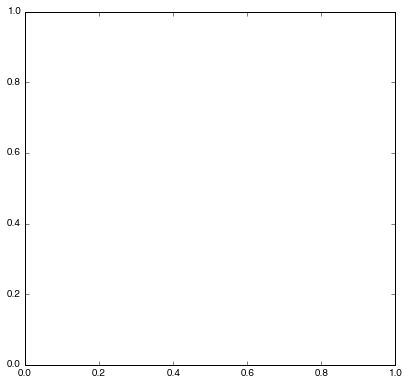

In [114]:
dict_population = {'parents':0, 'ancestral':1, 'evolved':2}
dict_background = {'WA':0, 'NA':1, 'WAxNA':2}
dict_gene = {'RNR2':0, 'RNR4':1, 'no driver':2, 'FPR1':3, 'TOR1':4}
dict_genotype = {'RNR2':0, 'RNR2*':2, 'RNR4':1, 'RNR4*':3,
                 'no driver':0, 'FPR1*':2, 'TOR1':1, 'TOR1*':3}
dict_panels = {
'WAxNA': {'HU':(0,0),'RM':(0,1)},
'WAxNA-WExSA': {'HU':(1,0),'RM':(1,1)}
}

# apply sorting ranks to reorder rows    
hybrids_norm_df.loc[:,u'rank_background_MATa'] = hybrids_norm_df[u'background_MATa'].map(dict_background)
hybrids_norm_df.loc[:,u'rank_background_MATα'] = hybrids_norm_df[u'background_MATα'].map(dict_background)
hybrids_norm_df.loc[:,u'rank_genotype_MATa'] = hybrids_norm_df[u'genotype_MATa'].map(dict_genotype)
hybrids_norm_df.loc[:,u'rank_genotype_MATα'] = hybrids_norm_df[u'genotype_MATα'].map(dict_genotype)
hybrids_norm_df.loc[:,u'rank_population_MATa'] = hybrids_norm_df[u'population_MATa'].map(dict_population)
hybrids_norm_df.loc[:,u'rank_population_MATα'] = hybrids_norm_df[u'population_MATα'].map(dict_population)
hybrids_norm_df.sort(columns=[u'rank_population_MATa',u'rank_population_MATα',
                              u'rank_background_MATa',u'rank_background_MATα',
                              u'rank_genotype_MATa',u'rank_genotype_MATα',
                              u'tetrad_MATa',u'tetrad_MATα',
                              u'spore_MATa',u'spore_MATα'],
                ascending=[True,True,True,True,True,True,True,True,True,True],inplace=True)

# environment attributes
environments = {u'HU': u'YNB+HU 10 mg/ml', 
                u'RM': u'YNB+RM 0.025 μg/ml', 
                u'YNB': u'YNB (control)'}

param='growth_rate'

fig = plt.figure(figsize=(13,13))

for (background,env_test) in [('WAxNA','HU'),('WAxNA','RM'),('WAxNA-WExSA','HU'),('WAxNA-WExSA','RM')]:
    ax = plt.subplot2grid((2, 2), dict_panels[background][env_test])
    
    # spores
    gs = spores_norm_df.groupby(['background','Environment']).get_group((background,env_test))
    S = gs.groupby([u'mating',u'spore'], sort=False).agg(np.mean)[param]

    # hybrids
    gh = hybrids_norm_df.groupby(['background','Environment']).get_group(((background,background),env_test))
    gh = gh.groupby([u'spore_MATa',
                     u'spore_MATα'],
                    sort=False).agg(np.mean)[param]
    H = gh.unstack(level=[u'spore_MATα'])

    # plot
    pheno.heatmap_spores(S, radius=0.5)
    pheno.heatmap_hybrids(H, fold=False, title=environments[env_test], pad=100)

fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.95,hspace=0.05,wspace=0.60)
plt.show()